In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import matplotlib.pyplot as plt
from evallm.experiments.sequence_completion_summary import (
    sequence_completion_results,
    display_prompt as display_prompt_sc,
    sequence_completion_null_results,
)

from evallm.experiments.transducer_summary import (
    transducer_results,
    transducer_null_results,
)
from evallm.experiments.main_tables import (
    best_prompt,
    multi_prompts,
    main_table_of_results,
    multi_prompt_table_of_results,
    plot_transducer_vs_sequence_completion,
    best_prompt,
    all_p_values,
)
from evallm.experiments.main_tables import plot_significance

from evallm.experiments.transducer_plotting import produce_table
from evallm.experiments.models_display import model_by_display_key

In [3]:
null_t = transducer_null_results()
null_sc = sequence_completion_null_results()
results_t = transducer_results()
results_sc = sequence_completion_results()

### Main Table

In [4]:
main_table_of_results(best_prompt(results_t), best_prompt(results_sc))

{\renewcommand{\arraystretch}{1.25}\begin{tabular}{l|ccc|ccccc}
\hline
\bf Model & \bf Size & \bf IT? & \bf Code? & \bf Sequence Completion & \bf SR & \bf Transducer & \bf TR\\
\hline
\multicolumn{8}{c}{ \bf Baselines} \\
\hline
\textsc{BruteForce} & -- &  &  & \cellcolor{lightgray} 100.0 (99.9--100.0) & 1 & \cellcolor{lightgray} 96.4 (96.2--96.7) & 1 \\
\hline
6-\textsc{Gram} & -- &  &  & \bf 91.7 (91.0--92.4) & 2 & \bf 93.5 (93.1--93.9) & 3 \\
\hline
5-\textsc{Gram} & -- &  &  & 91.2 (90.4--91.9) & 3 & 93.4 (93.0--93.7) & 4 \\
\hline
4-\textsc{Gram} & -- &  &  & 89.6 (88.7--90.4) & 4 & 91.1 (90.6--91.6) & 6 \\
\hline
3-\textsc{Gram} & -- &  &  & 87.0 (86.1--87.8) & 5 & 87.0 (86.4--87.6) & 22 \\
\hline
2-\textsc{Gram} & -- &  &  & 83.3 (82.2--84.2) & 8 & 74.5 (73.6--75.3) & 30 \\
\hline
\textsc{Common-Suffix} & -- &  &  & 84.7 (83.6--85.6) & 6 & -- & -- \\
\hline
\textsc{Random}$_S$/\textsc{Null}$_T$ & -- &  &  & 53.3 (51.7--54.7) & 31 & 68.9 (68.2--69.6) & 31 \\
\hline
\multicolumn{8

### Comparison of Prompts

In [5]:
multi_prompt_table_of_results(multi_prompts(results_t), multi_prompts(results_sc))

{\renewcommand{\arraystretch}{1.25}\begin{tabular}{l|ccccc}
\hline
\bf Model & \bf \textsc{Basic} & \bf \textsc{Basic-COT} & \bf \textsc{More-Expl} & \bf \textsc{More-Expl-COT} & \bf \textsc{Red-Green} \\
\hline
\multicolumn{6}{l}{ \bf Sequence Completion} \\
\hline
gpt-4o-mini & \bf 72.4 (68.1--76.3) & -- & 70.5 (66.4--74.6) & 58.0 (53.4--62.4) & 59.1 (54.9--63.2) \\
\hline
gpt-4o & 72.1 (65.9--78.2) & -- & N/A & 67.4 (60.8--73.8) & \bf 74.4 (69.9--78.6) \\
\hline
claude-3.5 & N/A & -- & N/A & \bf 84.0 (79.3--88.4) & 80.0 (74.9--85.2) \\
\hline
o3-mini & N/A & -- & N/A & 58.2 (49.6--66.8) & \bf 69.8 (64.4--75.0) \\
\hline
\multicolumn{6}{l}{ \bf Transducer} \\
\hline
gpt-4o-mini & \bf 79.8 (77.3--82.2) & -- & 76.7 (74.2--79.3) & 65.2 (63.1--67.4) & 74.5 (72.0--77.0) \\
\hline
gpt-4o & \bf 83.7 (80.1--86.9) & -- & 82.6 (79.1--85.9) & 67.8 (63.1--72.3) & 82.6 (78.8--86.3) \\
\hline
claude-3.5 & 86.9 (83.3--90.0) & -- & \bf 87.1 (83.9--90.2) & 76.4 (72.9--79.9) & 82.9 (78.9--86.9) \\
\hl

### Commas

In [6]:
produce_table(
    {k: v for k, v in results_sc.items() if k in model_by_display_key},
    [display_prompt_sc(p) for p in ["Basic", "Basic-Commas"]],
)

\begin{tabular}{|r|c|c|}
\hline
Model & \textsc{Basic}$_S$ & \textsc{Basic-Commas}$_S$\\
\hline
\bf qwen-2.5-coder-7B &\bf 79.5 (78.4--80.5)&\bf 60.7 (59.3--62.1)\\
\hline
qwen-2.5-coder-instruct-7B &79.5 (78.3--80.5)&55.5 (54.0--56.9)\\
\hline
qwen-2.5-coder-instruct-32B &79.2 (78.0--80.3)&55.2 (53.7--56.7)\\
\hline
mistral-nemo-minitron-8B &78.7 (77.5--79.8)&59.3 (57.9--60.8)\\
\hline
codestral-22B &78.0 (76.8--79.1)&59.0 (57.5--60.3)\\
\hline
qwen-2.5-32B &76.8 (75.5--78.0)&60.3 (58.9--61.6)\\
\hline
deepseek-coder-33b-instruct &76.7 (75.3--77.8)&54.9 (53.0--56.8)\\
\hline
mistral-nemo-base-12B &75.5 (74.3--76.6)&60.6 (59.1--62.2)\\
\hline
llama3.1-8B-Instruct &75.3 (74.0--76.6)&56.3 (54.4--58.1)\\
\hline
llama3.1-8B &75.2 (73.8--76.3)&61.1 (59.8--62.5)\\
\hline
llama3-8B &73.8 (72.4--75.1)&61.5 (60.2--62.9)\\
\hline
starcoder2-15b &73.5 (72.0--74.7)&58.2 (56.7--59.8)\\
\hline
qwen-2.5-7B &73.5 (72.1--74.8)&57.0 (55.5--58.5)\\
\hline
gemma-7b &72.6 (71.3--73.7)&54.0 (51.9--56.0)\\
\

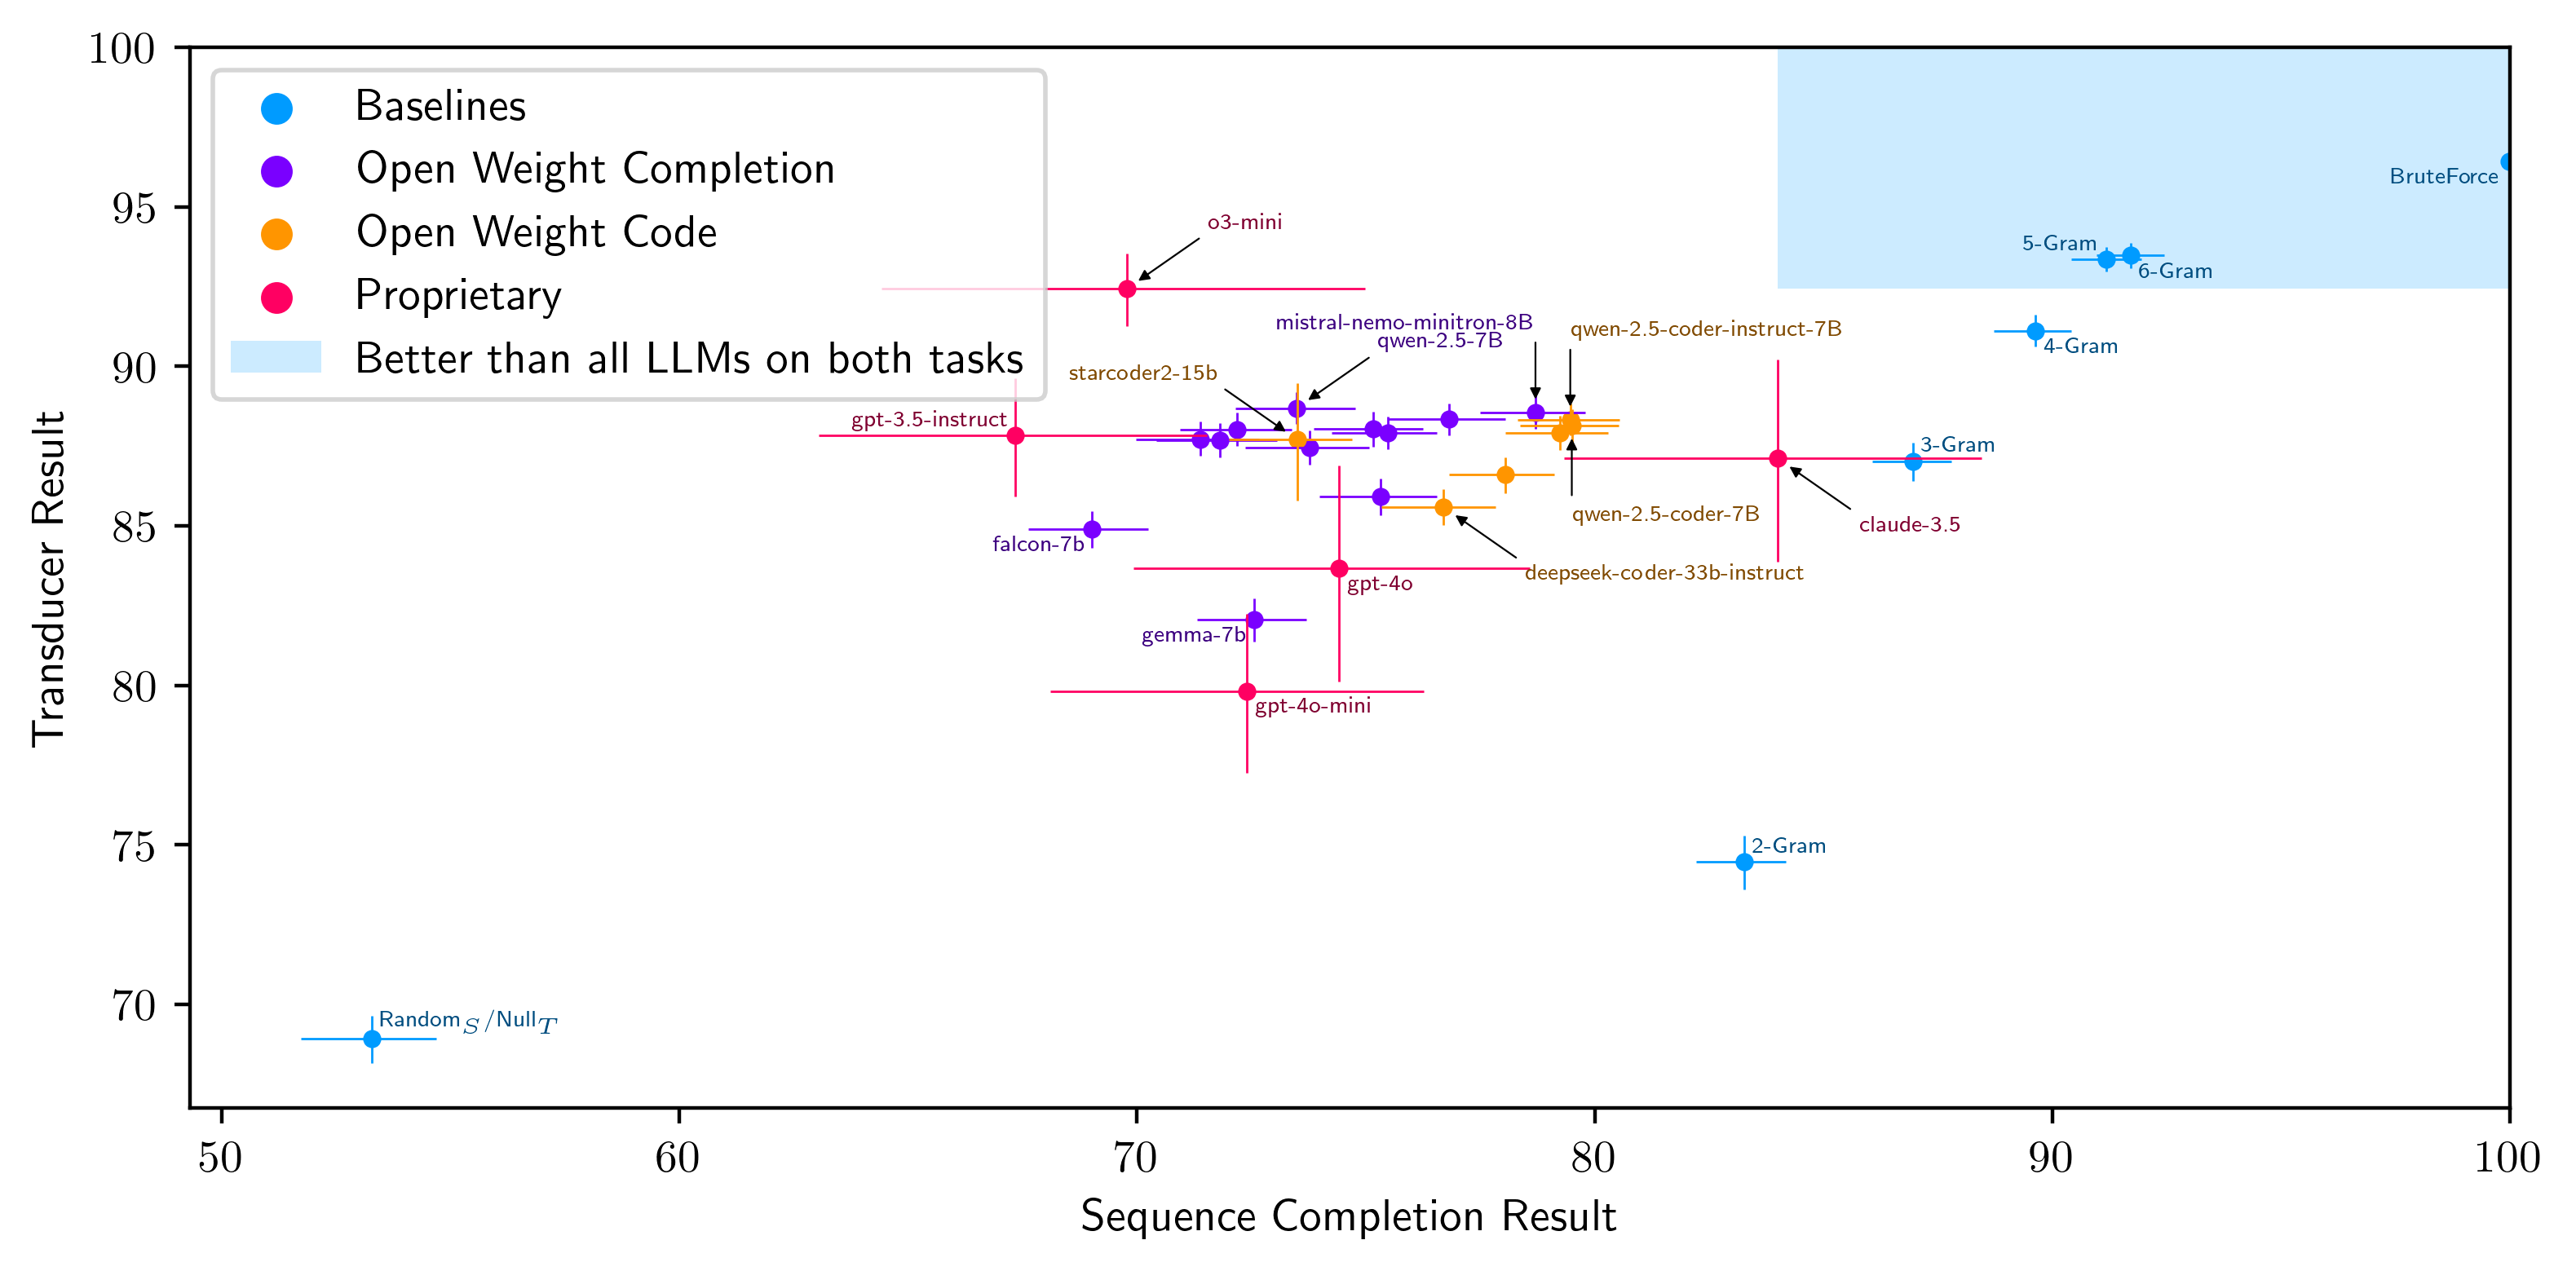

In [7]:
plt.figure(figsize=(8, 4), dpi=400, facecolor="white", tight_layout=True)
plot_transducer_vs_sequence_completion(results_sc, results_t)
plt.savefig("../output/sequence_completion_vs_transducer.png")

### Null

In [8]:
print(r"{\scriptsize")
multi_prompt_table_of_results(
    multi_prompts(null_t, minimum_number_prompts=1),
    multi_prompts(null_sc, minimum_number_prompts=1),
    bold_best=False,
)
print("}")

{\scriptsize
{\renewcommand{\arraystretch}{1.25}\begin{tabular}{l|ccccc}
\hline
\bf Model & \bf \textsc{Basic} & \bf \textsc{Basic-COT} & \bf \textsc{More-Expl} & \bf \textsc{More-Expl-COT} & \bf \textsc{Red-Green} \\
\hline
\multicolumn{6}{l}{ \bf Sequence Completion} \\
\hline
llama3-8B & 0.0 (0.0--0.0) & -- & -- & -- & -- \\
\hline
llama3-70B & 0.0 (0.0--0.0) & -- & -- & -- & -- \\
\hline
llama3.1-8B-Instruct & 0.0 (0.0--0.0) & -- & -- & -- & -- \\
\hline
llama3.1-8B & 0.0 (0.0--0.0) & -- & -- & -- & -- \\
\hline
llama3.1-70B & 0.0 (0.0--0.0) & -- & -- & -- & -- \\
\hline
mistral-nemo-minitron-8B & 0.0 (0.0--0.0) & -- & -- & -- & -- \\
\hline
mistral-nemo-base-12B & 0.0 (0.0--0.0) & -- & -- & -- & -- \\
\hline
mistral-nemo-instruct-12B & 0.0 (0.0--0.0) & -- & -- & -- & -- \\
\hline
gemma-7b & 0.0 (0.0--0.0) & -- & -- & -- & -- \\
\hline
falcon-7b & 0.0 (0.0--0.0) & -- & -- & -- & -- \\
\hline
starcoder2-15b & 0.0 (0.0--0.0) & -- & -- & -- & -- \\
\hline
codestral-22B & 0.0 (0.0--0.0

In [9]:
from evallm.experiments.main_tables import flat_pandas_table, reorderings

In [10]:
import numpy as np


def flat(result):
    return {(k1, k2): np.mean(v) for k1, k2v in result.items() for k2, v in k2v.items()}


for k, v in flat(null_sc).items():
    if v < 0.05:
        continue
    if "Commas" in k[1]:
        continue
    print(k, v)
    # print(k, np.mean(v))

all_vals = np.array(
    [
        np.mean(v)
        for null in (null_t, null_sc)
        for vs in null.values()
        for prompt, v in vs.items()
        if "Commas" not in prompt
    ]
)

all_vals[all_vals < 0.5].max(), all_vals[all_vals >= 0.6].min()

('gpt-3.5-chat', '\\textsc{Basic}$_S$') 0.9986666666666667
('gpt-4o', '\\textsc{More-Expl}$_S$') 1.0
('gpt-4o', '\\textsc{More-Expl-COT}$_S$') 0.05000000000000002
('gpt-4o', '\\textsc{Red-Green}$_S$') 0.08444444444444446
('claude-3.5', '\\textsc{Basic}$_S$') 0.9966666666666666
('claude-3.5', '\\textsc{More-Expl}$_S$') 0.9777777777777777
('o3-mini', '\\textsc{Basic}$_S$') 0.8022222222222222
('o3-mini', '\\textsc{More-Expl}$_S$') 0.9155555555555553
('o3-mini', '\\textsc{More-Expl-COT}$_S$') 0.056666666666666685


(np.float64(0.08444444444444446), np.float64(0.8022222222222222))

In [11]:
table_sc = flat_pandas_table(results_sc, null_sc)
table_t = flat_pandas_table(results_t, null_t)

In [12]:
table_sc

,,acc_ignore_na,null,acc_full,best_prompt
llama3-8B,\textsc{Basic}$_S$,0.737700,0.000000,0.737700,True
llama3-70B,\textsc{Basic}$_S$,0.713841,0.000033,0.713818,True
llama3.1-8B-Instruct,\textsc{Basic}$_S$,0.753133,0.000000,0.753133,True
llama3.1-8B,\textsc{Basic}$_S$,0.751500,0.000000,0.751500,True
llama3.1-70B,\textsc{Basic}$_S$,0.718079,0.000033,0.718055,True
mistral-nemo-minitron-8B,\textsc{Basic}$_S$,0.787033,0.000000,0.787033,True
mistral-nemo-base-12B,\textsc{Basic}$_S$,0.754733,0.000000,0.754733,True
mistral-nemo-instruct-12B,\textsc{Basic}$_S$,0.721800,0.000000,0.721800,True
gemma-7b,\textsc{Basic}$_S$,0.725533,0.000000,0.725533,True
falcon-7b,\textsc{Basic}$_S$,0.690200,0.000000,0.690200,True


In [13]:
print("Sequence just same model")
reorderings(table_sc, same_model=True)
print()
print("Transducer just same model")
reorderings(table_t, same_model=True)

Sequence just same model
('gpt-4o', '\\textsc{Basic}$_S$') is better than ('gpt-4o', '\\textsc{Red-Green}$_S$') on full accuracy; despite being worse on ignore-na accuracy

Transducer just same model
('gpt-4o-mini', '\\textsc{Red-Green}$_T$') is better than ('gpt-4o-mini', '\\textsc{More-Expl}$_T$') on full accuracy; despite being worse on ignore-na accuracy


In [14]:
print("Sequence just best prompt")
reorderings(table_sc, only_best_prompt=True)
print()
print("Transducer just best prompt")
reorderings(table_t, only_best_prompt=True)

Sequence just best prompt
falcon-7b is better than gpt-4o on full accuracy; despite being worse on ignore-na accuracy
gemma-7b is better than gpt-4o on full accuracy; despite being worse on ignore-na accuracy
gpt-4o-mini is better than gpt-4o on full accuracy; despite being worse on ignore-na accuracy
llama3-70B is better than gpt-4o on full accuracy; despite being worse on ignore-na accuracy
llama3-8B is better than gpt-4o on full accuracy; despite being worse on ignore-na accuracy
llama3.1-70B is better than gpt-4o on full accuracy; despite being worse on ignore-na accuracy
mistral-nemo-instruct-12B is better than gpt-4o on full accuracy; despite being worse on ignore-na accuracy
o3-mini is better than gpt-4o on full accuracy; despite being worse on ignore-na accuracy
qwen-2.5-7B is better than gpt-4o on full accuracy; despite being worse on ignore-na accuracy
starcoder2-15b is better than gpt-4o on full accuracy; despite being worse on ignore-na accuracy

Transducer just best prompt

In [15]:
flat_t = best_prompt(results_t)
ps_t = all_p_values(flat_t)
flat_sc = {
    k: v
    for k, v in best_prompt(results_sc).items()
    if not isinstance(v, float) or not np.isnan(v)
}
ps_sc = all_p_values(flat_sc)

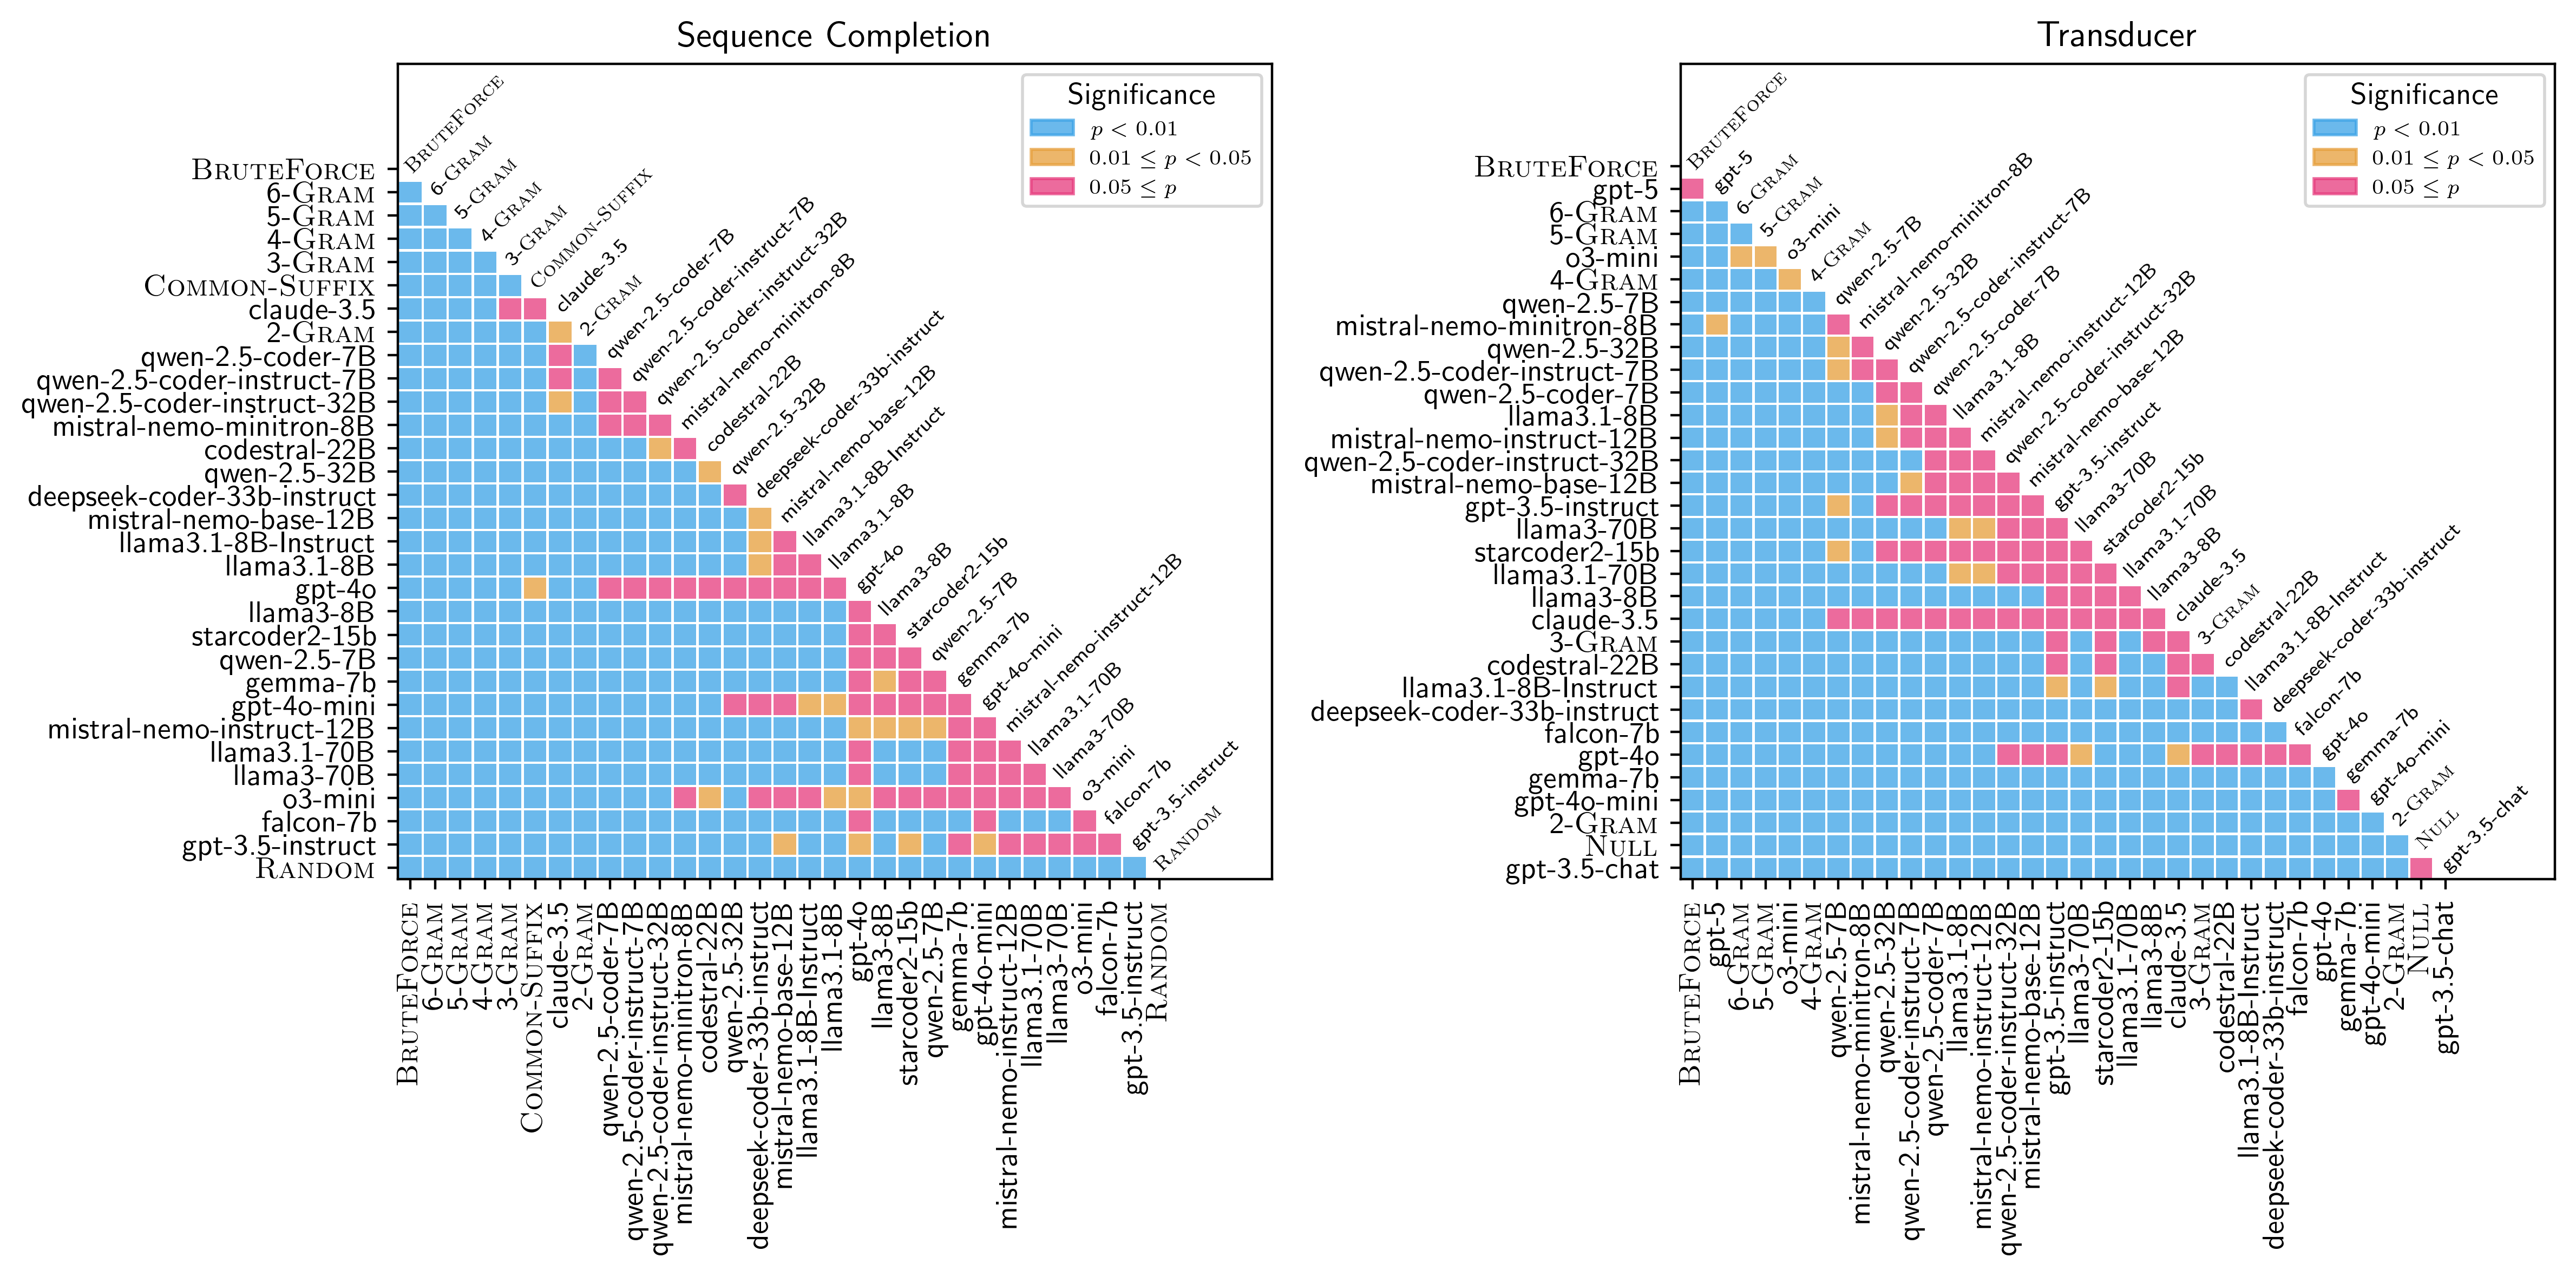

In [16]:
size = 6
_, axs = plt.subplots(1, 2, figsize=(size * 2, size), dpi=400, tight_layout=True)
plot_significance(axs[0], flat_sc, ps_sc)
axs[0].set_title("Sequence Completion")
plot_significance(axs[1], flat_t, ps_t)
axs[1].set_title("Transducer")
plt.savefig("../output/significance.png")
plt.show()